In [1]:
%matplotlib ipympl
import time
import traceback
from onix.data_tools import get_experiment_data
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile
import allantools
from tqdm import tqdm
from onix.analysis.t_violation import TViolation
from uncertainties import ufloat

In [2]:
def gaussian(f, f_0, a, sigma, b, c):
    numerator = (f - f_0) ** 2
    denominator = 2 * sigma ** 2
    return a * np.exp(-numerator / denominator) + c + b * (f - f_0)

def get_gaussian_fit(detunings, voltages, p0=None, bounds=None):
    fitter = Fitter(gaussian)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    fitter.set_p0({"f_0": 0, "c": 1, "b": 0, "sigma": 1})
    if p0 is not None:
        fitter.set_p0(p0)
    if bounds is not None:
        for bound_var, bound in bounds.items():
            fitter.set_bounds(bound_var, bound[0], bound[1])
    fitter.fit(maxfev = 10000)
    return fitter

def gaussian0(f, f0, a, sigma): 
    return a * np.exp( -(f - f0) **2 / (2 * sigma ** 2) )
    
def gaussianC(f, f0, a, sigma, c): 
    return a * np.exp( -(f - f0) **2 / (2 * sigma ** 2) ) + c

def get_gaussianC_fit(detunings, voltages, p0=None):
    fitter = Fitter(gaussianC)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    if p0 is not None:
        fitter.set_p0(p0)
    fitter.fit()
    
    return fitter

def two_peak_gaussian(f, f1, f2, a1, a2, sigma1, sigma2, b, c):
    return gaussian0(f, f1, a1, sigma1) + gaussian0(f, f2, a2, sigma2) + c + b * f

def four_peak_gaussian(f, f1, f2, f3, f4, a1, a2, a3, a4, sigma1, sigma2, sigma3, sigma4):
    return gaussian0(f, f1, a1, sigma1) + gaussian0(f, f2, a2, sigma2) + gaussian0(f, f3, a3, sigma3) + gaussian0(f, f4, a4, sigma4) + c

def linear(x, a, b):
    return x * a + b

In [3]:
def averaged_data_from_number(data_number):
    data, headers = get_experiment_data(data_number)
    transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"])
    monitors_avg = group_and_average_data(data["monitors_avg"], headers["params"]["detect"]["cycles"])
    return (transmissions_avg, monitors_avg, headers)

In [4]:
def gaussian_fits_from_data(transmissions_avg, monitors_avg, headers, default_p0=None):
    antihole_avg = transmissions_avg["antihole"]
    rf_avg = transmissions_avg["rf"]
    if "chasm" in transmissions_avg:
        chasm_avg = transmissions_avg["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        antihole_normalized = antihole_avg
        rf_normalized = rf_avg

    detunings = headers["detunings"].to("MHz").magnitude
    use_field_plate = headers["params"]["field_plate"]["use"]
    positive_field_plate = headers["params"]["field_plate"]["amplitude"] > 0

    p0 = {"sigma": 1, "a": -0.05}
    if default_p0 is None:
        default_p0 = {}
    p0.update(default_p0)
    
    if not use_field_plate:
        fits = {0: {}}
        antihole_fit = get_gaussian_fit(detunings, antihole_normalized, p0=p0)
        fits[0]["ah"] = antihole_fit
        
        rf_fit = get_gaussian_fit(detunings, rf_normalized, p0=p0)
        fits[0]["rf"] = rf_fit
    else:
        fits = {1: {}, -1: {}}
        for label in fits.keys():
            use_positive_stark_shift = label > 0
            if use_positive_stark_shift:
                mask = detunings > 0
            else:
                mask = detunings < 0
            p0["f_0"] = label * abs(headers["params"]["field_plate"]["stark_shift"].to("MHz").magnitude)
            antihole_fit: Fitter = get_gaussian_fit(detunings[mask], antihole_normalized[mask], p0=p0)
            fits[label]["ah"] = antihole_fit
            
            rf_fit: Fitter = get_gaussian_fit(detunings[mask], rf_normalized[mask], p0=p0)
            fits[label]["rf"] = rf_fit
    return fits

In [5]:
def ah_parameters_from_data(transmissions_avg, monitors_avg, headers):
    antihole_avg = transmissions_avg["antihole"]
    rf_avg = transmissions_avg["rf"]
    if "chasm" in transmissions_avg:
        chasm_avg = transmissions_avg["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        antihole_normalized = antihole_avg
        rf_normalized = rf_avg

    detunings = headers["detunings"].to("MHz").magnitude
    use_field_plate = headers["params"]["field_plate"]["use"]
    positive_field_plate = headers["params"]["field_plate"]["amplitude"] > 0
    
    if not use_field_plate:
        off_resonant_index = np.argmax(np.abs(detunings) > 0)
        on_resonant_index = 1 - off_resonant_index
        heights = {0: {}}
        backgrounds = {0: {}}
        heights[0]["ah"] = 1 - antihole_avg[on_resonant_index] / antihole_avg[off_resonant_index]
        heights[0]["rf"] = 1 - rf_avg[on_resonant_index] / rf_avg[off_resonant_index]
        backgrounds[0]["ah"] = antihole_avg[off_resonant_index]
        backgrounds[0]["rf"] = rf_avg[off_resonant_index]
    else:
        off_resonant_index_1 = 1
        off_resonant_index_2 = 0
        # off_resonant_index_2 = 1
        on_resonant_index_1 = 3
        on_resonant_index_2 = 2

        heights = {1: {}, -1: {}}
        backgrounds = {1: {}, -1: {}}

        heights[1]["ah"] = 1 - antihole_avg[on_resonant_index_1] / antihole_avg[off_resonant_index_1]
        heights[1]["rf"] = 1 - rf_avg[on_resonant_index_1] / rf_avg[off_resonant_index_1]
        heights[-1]["ah"] = 1 - antihole_avg[on_resonant_index_2] / antihole_avg[off_resonant_index_2]
        heights[-1]["rf"] = 1 - rf_avg[on_resonant_index_2] / rf_avg[off_resonant_index_2]

        backgrounds[1]["ah"] = antihole_avg[off_resonant_index_1]
        backgrounds[1]["rf"] = rf_avg[off_resonant_index_1]
        backgrounds[-1]["ah"] = antihole_avg[off_resonant_index_2]
        backgrounds[-1]["rf"] = rf_avg[off_resonant_index_2]
    return (heights, backgrounds)

In [6]:
def rf_spectroscopy_ah_ratio(data_numbers, method="auto"):
    rf_heights = {}
    antihole_heights = {}
    rf_backgrounds = {}
    antihole_backgrounds = {}
    headers = []
    for data_number in data_numbers:
        try:
            transmissions_avg, monitors_avg, headers_single = averaged_data_from_number(data_number)
            if method == "auto":
                detunings_len = len(headers_single["detunings"])
                if detunings_len > 4:
                    method = "fit"
                else:
                    method = "ratio"
            if method == "fit":
                try:
                    fits = gaussian_fits_from_data(transmissions_avg, monitors_avg, headers_single)
                except RuntimeError as e:
                    print(f"Fitting error for data number #{data_number}:")
                    raise e
                for label in fits:
                    if label not in rf_heights:
                        rf_heights[label] = []
                        antihole_heights[label] = []
                        rf_backgrounds[label] = []
                        antihole_backgrounds[label] = []
                    rf_heights[label].append(abs(fits[label]["rf"].results["a"]) / fits[label]["rf"].results["c"])
                    antihole_heights[label].append(abs(fits[label]["ah"].results["a"]) / fits[label]["ah"].results["c"])
                    rf_backgrounds[label].append(fits[label]["rf"].results["c"])
                    antihole_backgrounds[label].append(fits[label]["ah"].results["c"])
            elif method == "ratio":
                heights, backgrounds = ah_parameters_from_data(transmissions_avg, monitors_avg, headers_single)
                # heights, backgrounds = ah_parameters_from_data1(data_number)
                for label in heights:
                    if label not in rf_heights:
                        rf_heights[label] = []
                        antihole_heights[label] = []
                        rf_backgrounds[label] = []
                        antihole_backgrounds[label] = []
                    rf_heights[label].append(heights[label]["rf"])
                    antihole_heights[label].append(heights[label]["ah"])
                    rf_backgrounds[label].append(backgrounds[label]["rf"])
                    antihole_backgrounds[label].append(backgrounds[label]["ah"])
            headers.append(headers_single)
        except:
            continue
    for label in rf_heights:
        rf_heights[label] = np.array(rf_heights[label])
        antihole_heights[label] = np.array(antihole_heights[label])
        rf_backgrounds[label] = np.array(rf_backgrounds[label])
        antihole_backgrounds[label] = np.array(antihole_backgrounds[label])
    return (rf_heights, antihole_heights, rf_backgrounds, antihole_backgrounds, headers)

In [7]:
def data_identification_to_list(data_identification):
    if isinstance(data_identification, tuple):
        return range(data_identification[0], data_identification[1] + 1)
    elif isinstance(data_identification, int):
        return [data_identification]
    else:
        # it should be a list
        return data_identification

## Test HSH Pulse vs Sine Sweep

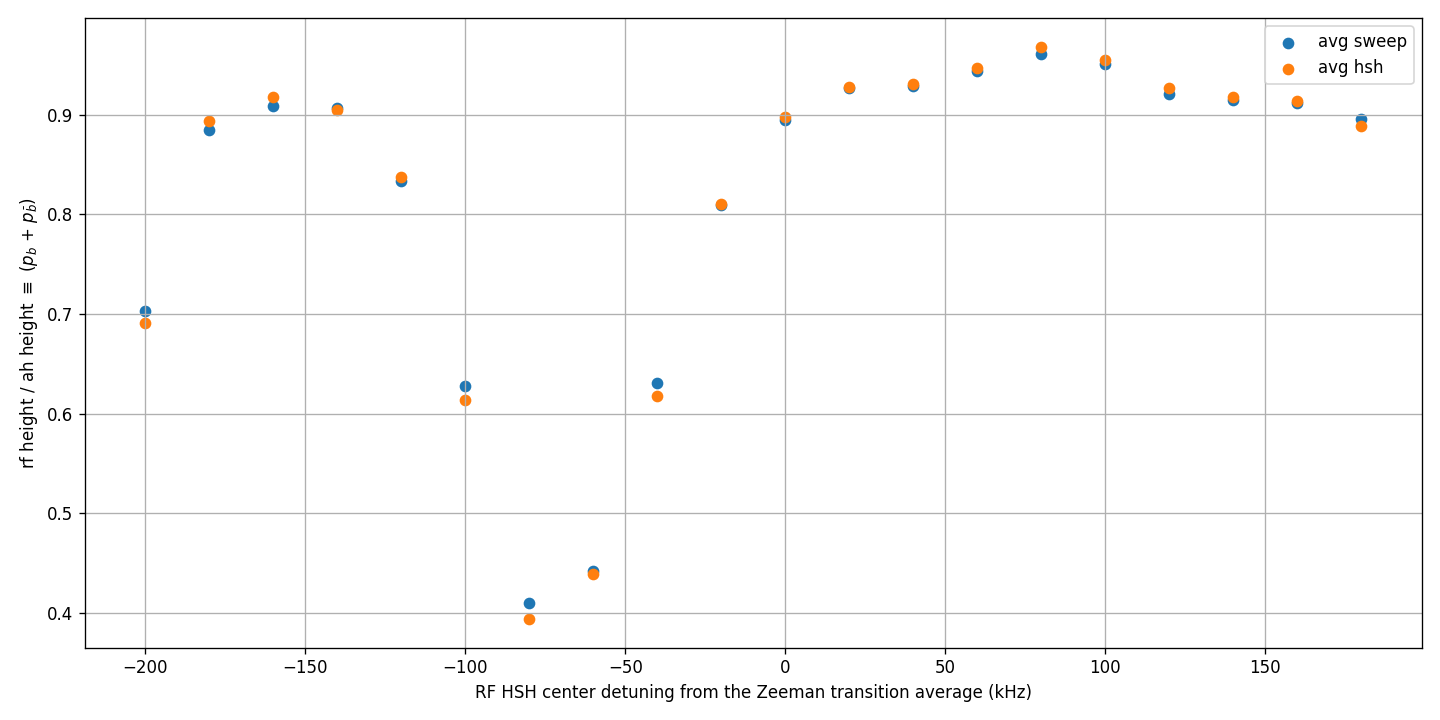

In [8]:
#data = {
    #"rf sweep": (328868, 328882), # scan rf center_detuning from -200kHz to 200kHz. Each step has 50kHz scan
    #"rf sweep 2": (329553, 329572),
    #"rf hsh 10 kHz scan range": (329204, 329223), # scan rf center_detuning from -200kHz to 200kHz. Each step has 10kHz scan
    #"rf hsh": (329224, 329243), # scan rf center_detuning from -200kHz to 200kHz. Each step has 50kHz scan
    #"rf hsh 2": (329533,329552),
#}

data = {
    "rf sweep": (329617, 329636), # scan rf center_detuning from -200kHz to 200kHz. Each step has 50kHz scan
    "rf sweep 2": (329637, 329656),
    "rf sweep 3": (329657, 329676),
    "rf sweep 4": (329677, 329696),
    "rf sweep 5": (329697, 329716),
    "rf hsh": (329717, 329736), # scan rf center_detuning from -200kHz to 200kHz. Each step has 50kHz scan
    "rf hsh 2": (329737, 329756),
    "rf hsh 3": (329757, 329776),
    "rf hsh 4": (329777, 329796),
    "rf hsh 5": (329797, 329816),
}


fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
sweeps = []
hsh_pulses = []
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["rf"]["center_detuning"].to("kHz").magnitude for header in headers]
    ys = rf_heights[0] / ah_heights[0]
    if "sweep" in label:
        sweeps.append(ys)
    elif "hsh" in label:
        hsh_pulses.append(ys)
    #ax.scatter(xs, ys, label=label)

avg_sweep = np.mean(sweeps, axis = 0)
avg_hsh = np.mean(hsh_pulses, axis = 0)
ax.scatter(xs, avg_sweep, label = "avg sweep")
ax.scatter(xs, avg_hsh, label = "avg hsh")
ax.set_xlabel("RF HSH center detuning from the Zeeman transition average (kHz)")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

## LF Spectroscopy on b, bbar Transition

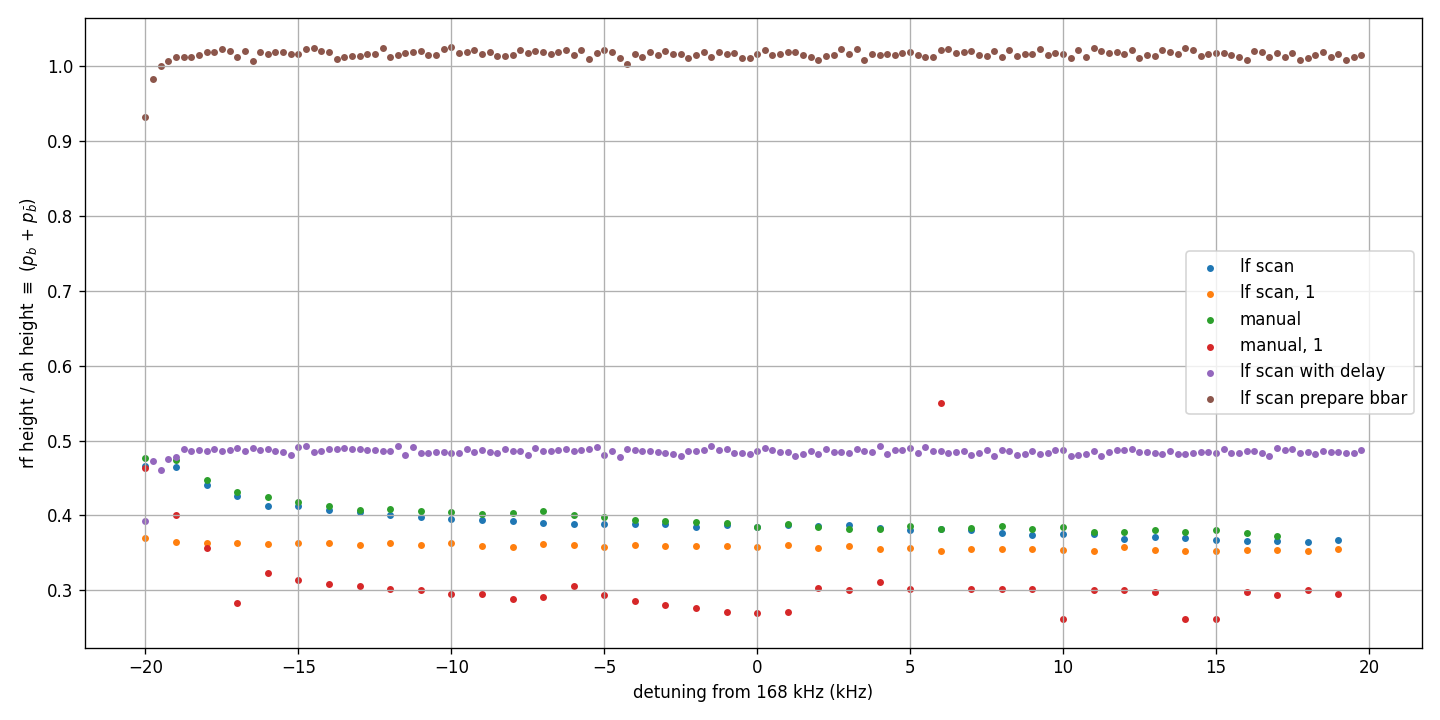

In [19]:
data = {
    "lf scan": (328888, 328927), # heating is an issue, nothing shows
    "lf scan, 1": (328928, 328967), # repeat of above
    "manual": (329029, 329066), # switch AWG for function generator
    "manual, 1": (329069, 329108), #repeat of above
    #"lf off": (329266,329384), # no lf, shows background due to heating
    #"lf scan, 2": (329385,329464) # same as first two
    #"lf scan with delays": (329817, 329896), # step size 0.5 kHz, 1 s delay between steps
    "lf scan with delay": (329897, 330056), # step size 0.25 kHz, 1 s delay between steps
    "lf scan prepare bbar": (330097, 330256)
}
fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["lf"]["detuning"].to("kHz").magnitude for header in headers]
    ys = rf_heights[0] / ah_heights[0]
    ax.scatter(xs, ys, label=label, s = 10)

ax.set_xlabel("detuning from 168 kHz (kHz)")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

## Testing RF and Optical Parts

### Ensure that all sequences are shorter than 0.1 s antihole lifetime. Add delays between experiments to prevent heating

In [ ]:
# prepare into bbar. Drive ab rf transition. Optical detection. Should see no change.
# prepare into b. Drive rf ab transition. Should see all population dissapear

Fitting error for data number #330057:


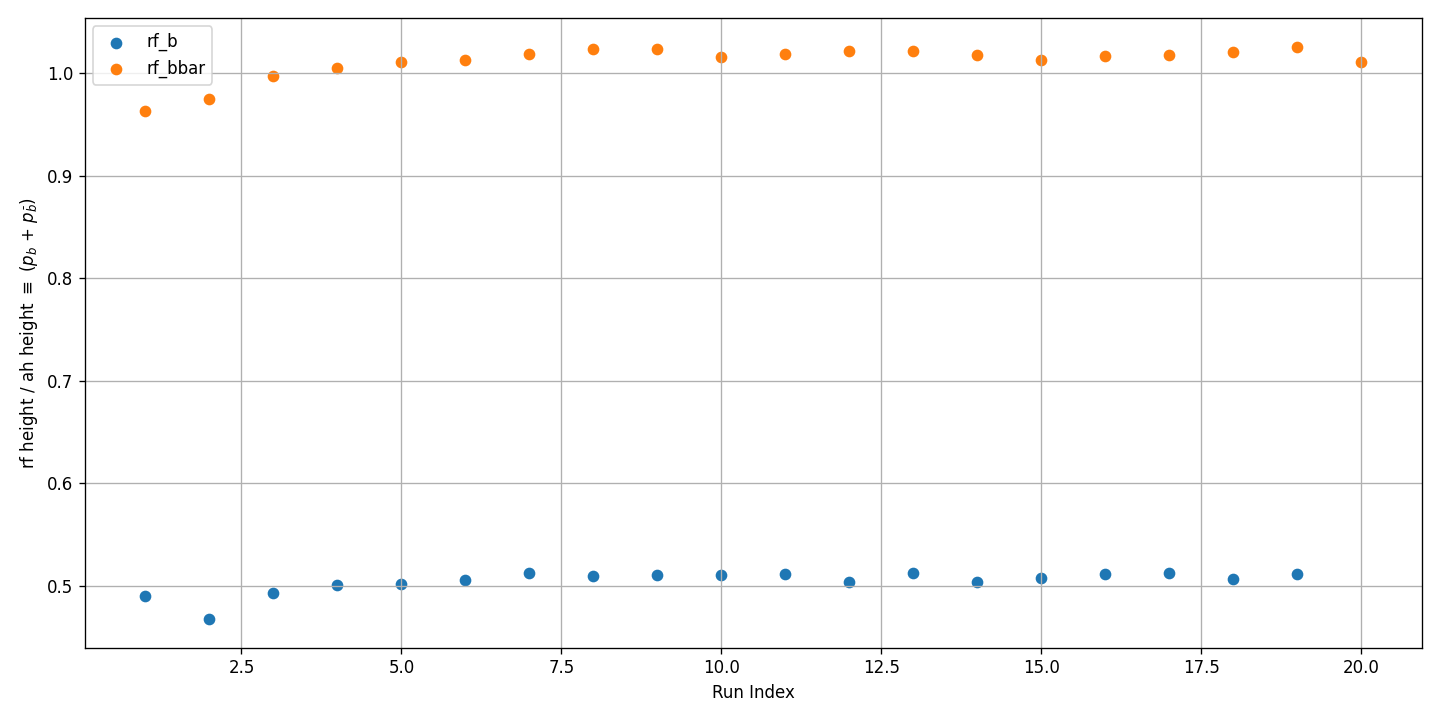

In [18]:
data = {
    "rf_b": (330057, 330076),
    "rf_bbar": (330077, 330096),
}
fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    ys = rf_heights[0] / ah_heights[0]
    xs = np.linspace(1,len(ys), len(ys))
    ax.scatter(xs, ys, label=label)

ax.set_xlabel("Run Index")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()